In [1]:
import os

import torch
import wandb
from hydra import compose, initialize
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

from src.components.cdvi import load_from_cfg
from src.utils.eval import (compute_bd, compute_jsd, create_grid,
                            eval_dist_on_grid, eval_kde_on_grid,
                            normalize_vals_on_grid)
from src.utils.train import train
from src.utils.visualize import (visualize_cdvi_for_bml, visualize_samples_2d,
                                 visualize_vals_on_grid_2d)

In [2]:
try:
    import torch_directml
    device = torch_directml.device() 
except ImportError:
    device = torch.device("cpu") 
print(device)

privateuseone:0


In [3]:
dir = "../models/test" 

In [4]:
with initialize(version_base=None, config_path=dir):
    cfg = compose(config_name="config")

    cdvi, dataloader, optimizer = load_from_cfg(cfg, device)

    cdvi_path = f"{dir}/cdvi.pth"
    optim_path = f"{dir}/optim.pth"

    if os.path.exists(cdvi_path):
        cdvi_state_dict = torch.load(cdvi_path, map_location=torch.device("cpu"), weights_only=True)
        cdvi.load_state_dict(cdvi_state_dict)
        print(f"loaded cdvi from {cdvi_path}")

    if os.path.exists(optim_path):
        optim_state_dict = torch.load(optim_path, map_location=torch.device('cpu'), weights_only=True)
        optimizer.load_state_dict(optim_state_dict)
        print(f"loaded optim from {optim_path}")

Generating tasks: 100%|██████████| 4096/4096 [00:00<00:00, 274237.29it/s]


In [5]:
wandb_logging = False

if wandb_logging:
    wandb.init(project="dvi-bml-test")

In [ ]:
do_train = True

num_epochs = 1000
scheduler = None #ReduceLROnPlateau(optimizer, mode="min", factor=0.3, patience=500)
# params = [
#     {"params": dvi_process.parameters(), "lr": config.learning_rate},
#     {"params": set_encoder.parameters(), "lr": config.learning_rate},
#     {"params": decoder.parameters(), "lr": config.learning_rate}
# ]

if do_train:
    losses = train(
        device=device, 
        contextual_dvi=cdvi,
        target_constructor=None,
        num_epochs=num_epochs,
        dataloader=dataloader, 
        optimizer=optimizer, 
        scheduler=scheduler,
        max_clip_norm=cfg.training.max_clip_norm,
        wandb_logging=wandb_logging,
        alpha=cfg.training.alpha
    )

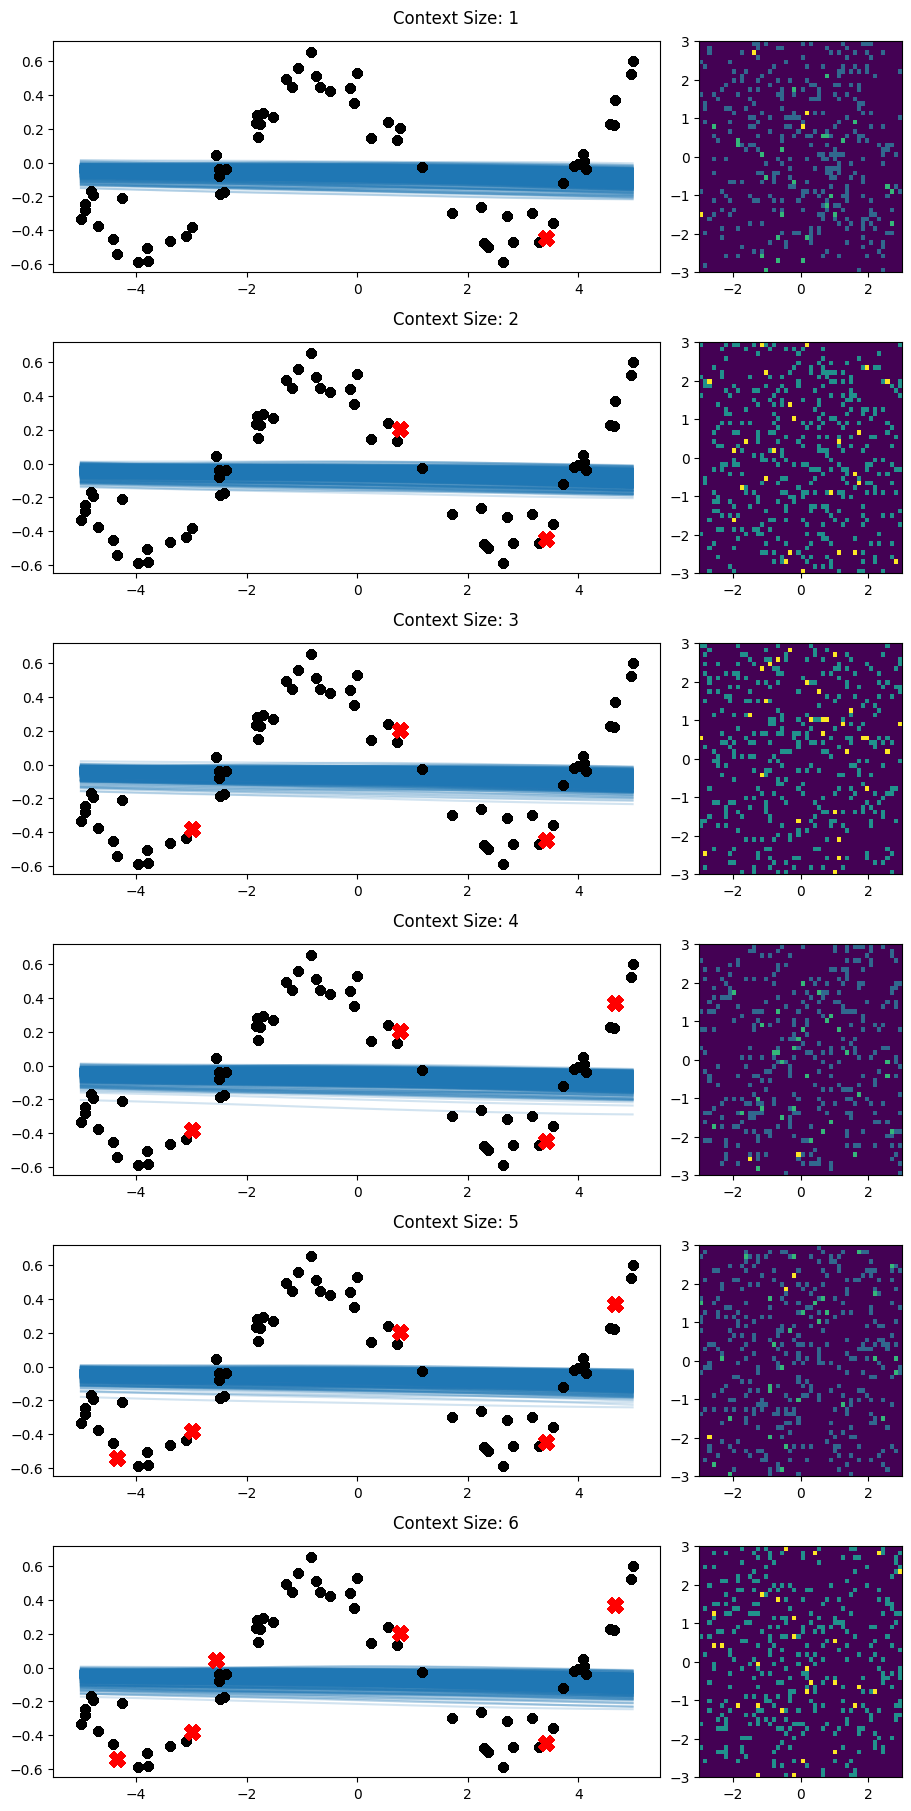

In [7]:
max_context_size = 6
num_samples = 1024
gen_dataloader = DataLoader(dataloader.dataset, 1, True)

targets, samples = visualize_cdvi_for_bml(
    device=device,
    cdvi=cdvi,
    dataloader=gen_dataloader,
    config=cfg,
    num_samples=num_samples,
    max_context_size=max_context_size
)

2.4645224134578294 nan


/home/chickencurry/dvi-for-bml/src/utils/eval.py:98: RuntimeWarning: invalid value encountered in divide
  p_vals = p_vals / np.sum(p_vals)


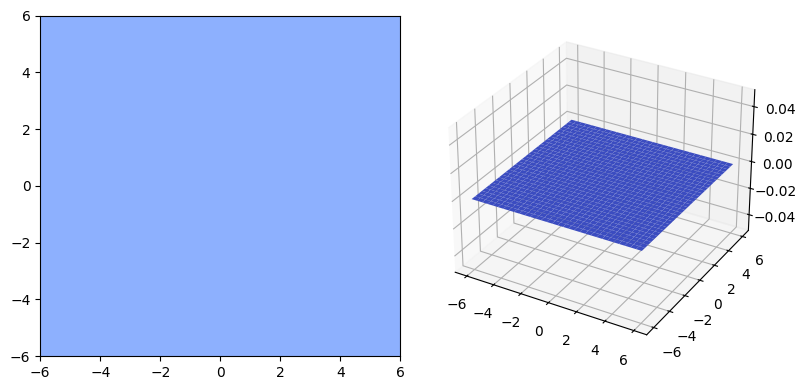

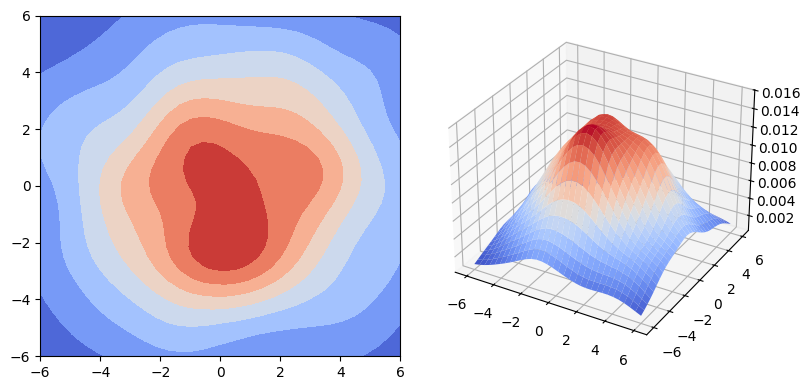

2.6247106627159087 0.6103927184228315


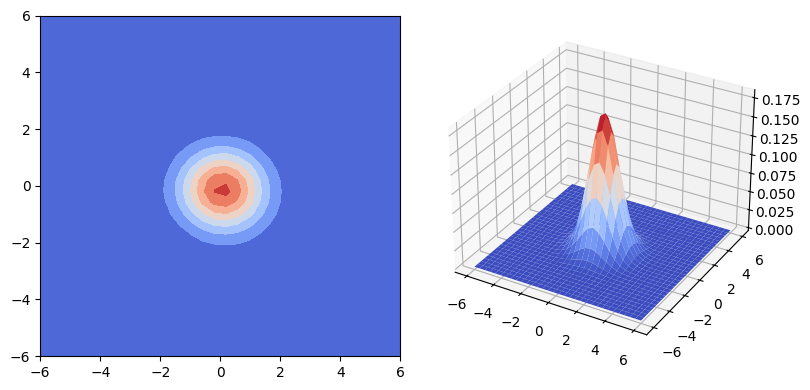

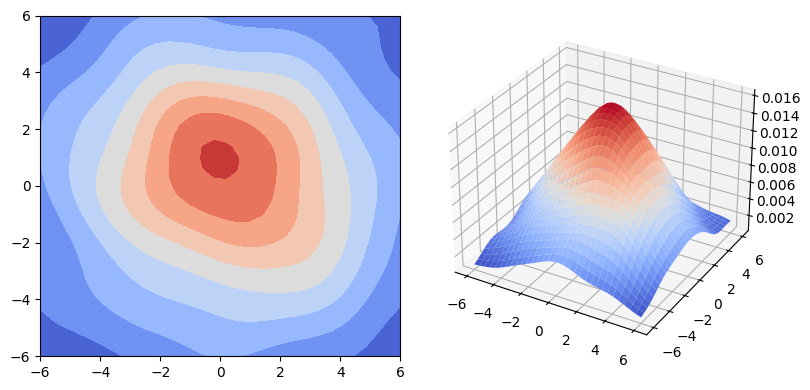

2.464522412868865 nan


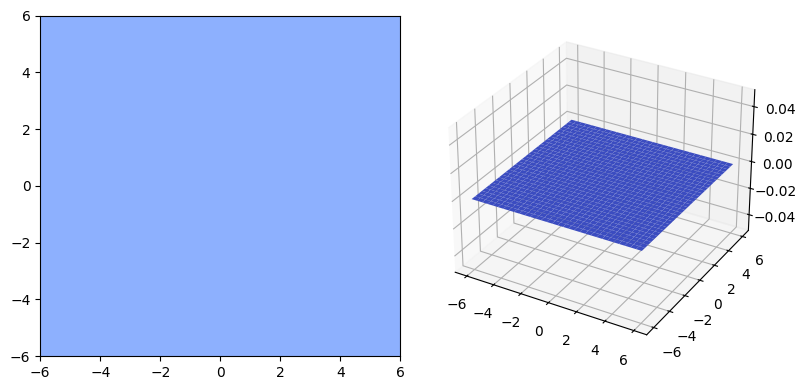

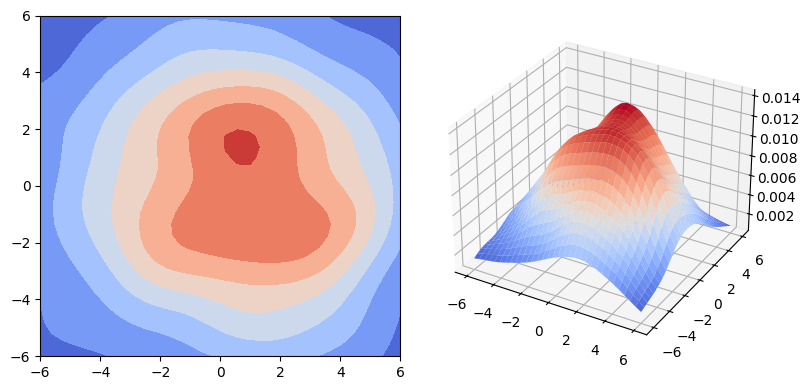

2.4645224129012795 nan


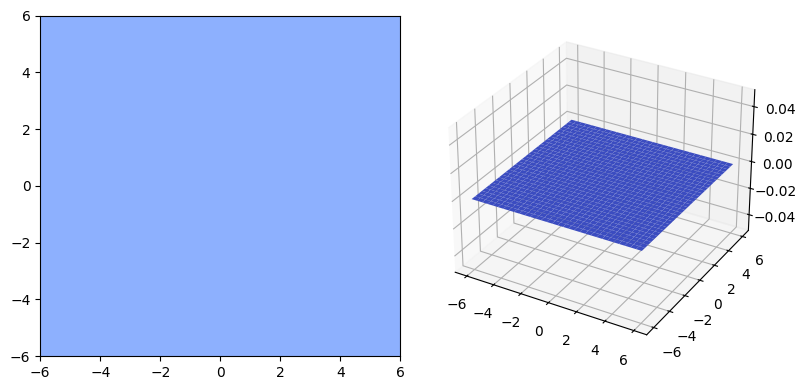

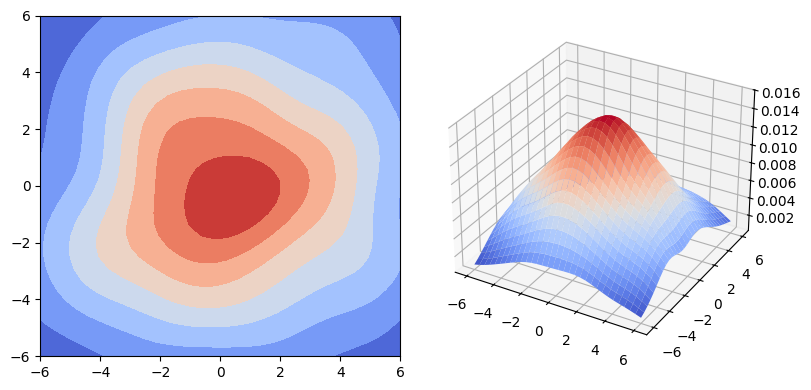

2.4645224136600965 nan


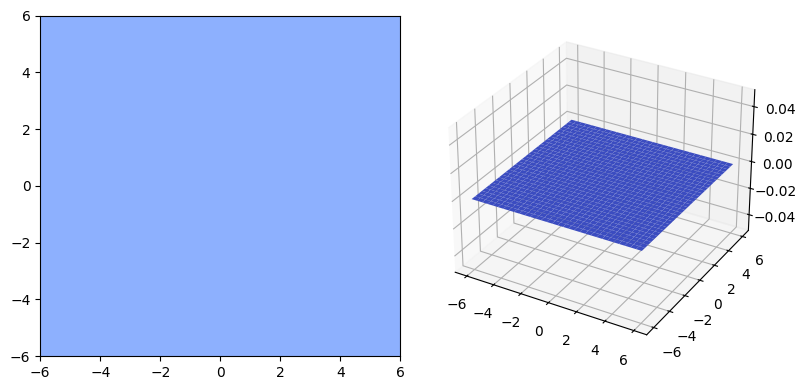

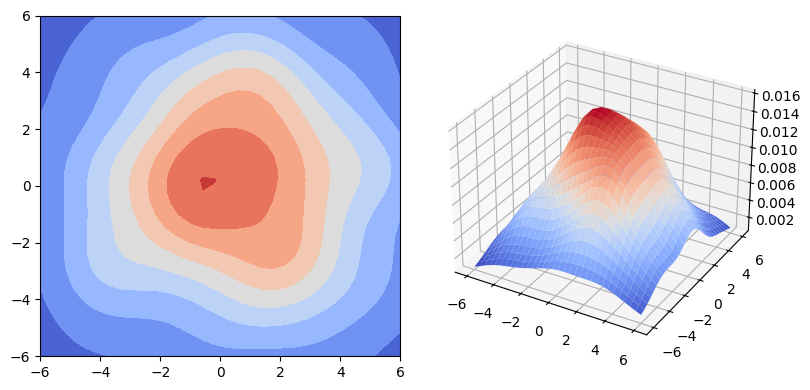

2.4645224116586038 nan


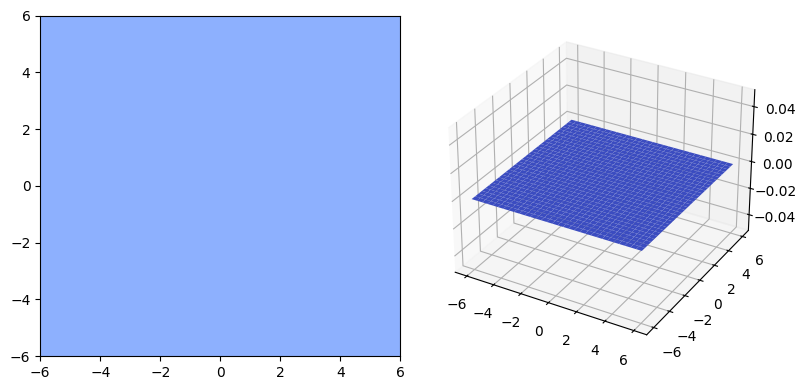

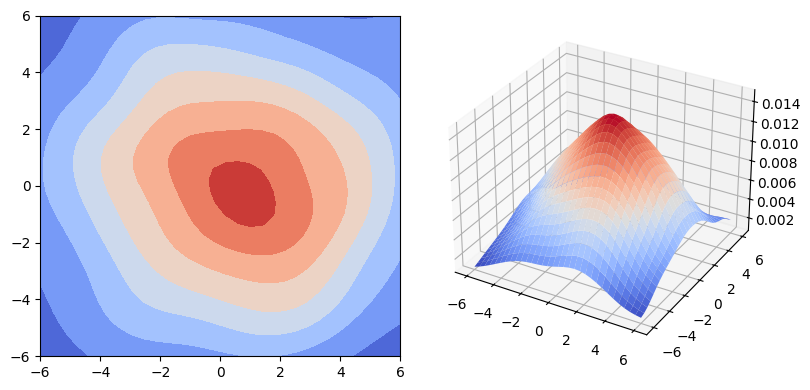

In [9]:
mins = [-6, -6]
maxs = [6, 6]
num = 32
grid = create_grid(mins, maxs, num)

for i in range(len(targets)):
    target_vals = eval_dist_on_grid(grid, targets[i], device=device)
    target_vals = normalize_vals_on_grid(target_vals, mins=mins, maxs=maxs, num=num)

    dvi_vals = eval_kde_on_grid(grid, samples[i])
    dvi_vals = normalize_vals_on_grid(dvi_vals, mins=mins, maxs=maxs, num=num)

    jsd = compute_jsd(target_vals, dvi_vals)
    bd = compute_bd(target_vals, dvi_vals)

    print(jsd, bd)

    visualize_vals_on_grid_2d(grid, target_vals)
    visualize_vals_on_grid_2d(grid, dvi_vals)

In [ ]:
torch.save(cdvi.state_dict(), f"{dir}/cdvi_finetuned.pth")